In [1]:
import os
import math
import argparse
import itertools
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import metrics

import utils
from datasets import Data, TransformerDataset
from models import FullyConnectedNetwork, PositionalEncoding

# Argument parser
# parser = argparse.ArgumentParser(description='Transformer Training Script')
# parser.add_argument('--output_dir', type=str, default='even', help='Specify a directory (to be created) for outputs')
# args = parser.parse_args()

# output_dir = args.output_dir
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)


N = int(1e4)

batch_size = 1024

# Number of epochs
# n_epochs = 100

print(f'Using {output_dir} numbered events for training')
print(f'Batch size: {batch_size}')
print('Taking N =', N, ' random events')

# get the device
device = utils.getDevice()
print(f"Using {device} device")

# get the data files
bamboo_results_dir = '../output/DYestimation-v1.2.8-3/results/'
rootFiles = os.listdir(bamboo_results_dir)


def listFiles(prefix):
    return [f'{bamboo_results_dir}{file}' for file in rootFiles if any(p in file for p in prefix)]


data_files = listFiles(['EGamma', 'Muon'])

print('Number of Data root files:', len(data_files))

treenames = [
    'DL_boosted_mumu_skim;1',
    'DL_boosted_ee_skim;1',
    'DL_resolved_mumu_skim;1',
    'DL_resolved_ee_skim;1'
]

# The variables for each object
input_features = {
    'l1': ['l1_pt', 'l1_eta', 'l1_phi', 'l1_E'],
    'l2': ['l2_pt', 'l2_eta', 'l2_phi', 'l2_E'],
}

n_objects = len(input_features)
n_features = len(input_features['l1'])

assert n_features == len(input_features['l2'])

data_Data = Data(
    name='Data',
    files=data_files,
    treenames=treenames,
    N=N
)

data_set = [data_Data]

for data in data_set:
    print(f'{data.name} : {data["event_no"].shape[0]} events')

branches = list(itertools.chain.from_iterable(
    list(input_features.values())))

weight_branch = 'weight'

branches = list(itertools.chain.from_iterable(
    list(input_features.values()))) + [weight_branch]

# Need to call them to load into memory
for data in data_set:
    start = time()
    for br in branches:
        data[br]
    print(f'Time passed loading {data.name} files:',
          round(time()-start, 2), 'seconds')


# Make pandas dataframes out of the data
# we're using `sample` to shuffle the data since using all of data is
# computationally expensive and we want to take a really random subset
df = pd.concat([data.get_df.sample(n=min(N, len(data.get_df)))
               for data in data_set])

Using outputs numbered events for training
Batch size: 1024
Taking N = 10000  random events
Using cuda device
Number of Data root files: 16
Tree DL_boosted_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_resolved_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_resolved_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/Muon_Run2022E.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/MuonEG_Run2022F.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/Muon_Run2022C.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/MuonEG_Run2022D.root
Tr

In [2]:
input_features

{'l1': ['l1_pt', 'l1_eta', 'l1_phi', 'l1_E'],
 'l2': ['l2_pt', 'l2_eta', 'l2_phi', 'l2_E']}

In [3]:
def compute_mll(leptons):
    """ to be used with lepton embdeddings
    leptons: Tensor of shape (2, 4) with features (pT, eta, phi, E)
    Returns: Tensor of shape (1) with invariant mass
    """
    # print(leptons.shape) # (batch_size, n_objects, n_features)
    pT, eta, phi, E = leptons[..., 0], leptons[...,
                                               1], leptons[..., 2], leptons[..., 3]

    px = pT * torch.cos(phi) # (batch_size, n_objects)
    py = pT * torch.sin(phi)
    pz = pT * torch.sinh(eta)

    E_tot = torch.sum(E, dim=-1) # (batch_size)
    px_tot = torch.sum(px, dim=-1)
    py_tot = torch.sum(py, dim=-1)
    pz_tot = torch.sum(pz, dim=-1)

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2) # (batch_size)
    mll = torch.sqrt(torch.clamp(m2, min=1e-6))  # avoid negative sqrt
    return mll # (batch_size)

In [4]:
df['l1_px2'] = (df['l1_pt'] * np.cos(df['l1_phi'])) ** 2
df['l1_py2'] = (df['l1_pt'] * np.sin(df['l1_phi'])) ** 2
df['l1_pz2'] = (df['l1_pt'] * np.sinh(df['l1_phi'])) ** 2
df['l1_E2'] = (df['l1_E']) ** 2

df['l2_px2'] = (df['l2_pt'] * np.cos(df['l2_phi'])) ** 2
df['l2_py2'] = (df['l2_pt'] * np.sin(df['l2_phi'])) ** 2
df['l2_pz2'] = (df['l2_pt'] * np.sinh(df['l2_phi'])) ** 2
df['l2_E2'] = (df['l2_E']) ** 2

input_features['l1'].extend(['l1_px2', 'l1_py2', 'l1_pz2', 'l1_E2'])
input_features['l2'].extend(['l2_px2', 'l2_py2', 'l2_pz2', 'l2_E2'])

n_features = len(input_features['l1'])

assert n_features == len(input_features['l2'])

print(input_features)

{'l1': ['l1_pt', 'l1_eta', 'l1_phi', 'l1_E', 'l1_px2', 'l1_py2', 'l1_pz2', 'l1_E2'], 'l2': ['l2_pt', 'l2_eta', 'l2_phi', 'l2_E', 'l2_px2', 'l2_py2', 'l2_pz2', 'l2_E2']}


In [5]:
df

,file,tree,sample,event_no,l1_pt,l1_eta,l1_phi,l1_E,l2_pt,l2_eta,...,l2_E,weight,l1_px2,l1_py2,l1_pz2,l1_E2,l2_px2,l2_py2,l2_pz2,l2_E2
47553,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_resolved_mumu_skim,Muon_Run2022F.root,1330313907,54.101871,-2.001556,-1.017181,203.847488,33.767834,-2.286530,...,167.865768,1.0,809.112488,2117.900146,4.228172e+03,41553.796875,898.850830,241.415787,58097.937500,28178.916016
5511,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_resolved_mumu_skim,Muon_Run2022E.root,460752797,48.599911,-0.258488,1.721466,50.232704,46.833347,0.043146,...,46.877064,1.0,53.215015,2308.736328,1.730750e+04,2523.324463,1269.104980,924.257507,1289.344482,2197.458984
88458,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022C.root,1072124318,38.680489,0.846436,-0.846802,53.384171,34.596905,-0.647461,...,42.105408,1.0,656.450012,839.730164,1.355128e+03,2849.869629,766.554993,430.390839,43684.257812,1772.865356
57351,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022D.root,67517832,43.151138,0.018169,2.160645,43.158264,38.192616,-1.170654,...,67.491425,1.0,576.104126,1285.916626,3.412102e+04,1862.635742,6.283156,1452.392822,8907.749023,4555.092285
72854,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022G.root,354953146,46.286377,0.520142,2.513184,52.690147,42.865852,0.650024,...,52.245342,1.0,1402.053467,740.375427,8.054730e+04,2776.251709,407.705048,1429.776245,3120.033691,2729.575684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121711,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_boosted_ee_skim,EGamma_Run2022F.root,2524131707,81.910912,-0.258972,0.805420,84.673035,63.726406,-1.125244,...,108.511482,1.0,3220.400635,3488.997070,5.378814e+03,7169.522949,4016.990234,44.064331,44.385399,11774.742188
136603,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022F.root,1580278139,88.629547,-0.600708,1.909424,105.107224,43.190327,-1.104736,...,72.337898,1.0,866.837280,6988.358887,8.556988e+04,11047.528320,1712.342407,153.062057,138745.765625,5232.771484
53959,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022D.root,545817809,57.872864,0.223053,-1.739746,59.318504,38.906078,0.223541,...,39.882214,1.0,94.695419,3254.572754,2.551646e+04,3518.685059,367.388428,1146.294556,23784.623047,1590.590942
125314,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_boosted_ee_skim,EGamma_Run2022F.root,138962416,244.925674,0.404480,-2.516113,265.235748,38.685005,1.027344,...,60.959671,1.0,39424.867188,20563.720703,2.268774e+06,70350.000000,164.458923,1332.070679,16277.375000,3716.081543


In [6]:
# Check for infinite or nan values
inf_indices = df.index[df.isin([np.inf, -np.inf]).any(axis=1)].tolist()
nan_indices = df.index[df.isna().any(axis=1)].tolist()

n_infs = len(inf_indices)
n_nans = len(nan_indices)

if n_infs > 0:
    print(f'Found {n_infs} row(s) that have infinite values in the dataframe.')
    print('Here are them: ', df.iloc[inf_indices])
    print('Removing them.')
    df = df.drop(inf_indices)


if n_nans > 0:
    print(f'Found {n_nans} row(s) that have NaN values in the dataframe.')
    print('Here are the them: ', df.iloc[nan_indices])
    print('Removing them.')
    df = df.drop(nan_indices)

In [7]:
# Split the data into training and validation sets

train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True)

dataset_train = TransformerDataset(
    df=train_df,
    variable_sets=list(input_features.values()),
    weight_branch=weight_branch,
    device=device,
)
dataset_test = TransformerDataset(
    df=valid_df,
    variable_sets=list(input_features.values()),
    weight_branch=weight_branch,
    device=device,
)

# DataLoader
train_dataloader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False
)

print(
    f'Training set   = {len(dataset_train)} events ({len(train_dataloader)} batches)')
print(
    f'Validation set = {len(dataset_test)} events ({len(test_dataloader)} batches)')

Training set   = 8000 events (8 batches)
Validation set = 2000 events (2 batches)


In [8]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[[ 1.0795e+02,  1.6370e+00,  5.2788e-02,  ...,  3.2443e+01,
           3.2504e+01,  8.2894e+04],
         [ 5.1482e+01,  1.6799e+00,  1.3445e+00,  ...,  2.5170e+03,
           8.4710e+03,  2.0422e+04]],

        [[ 1.1377e+02, -1.2856e+00,  6.6855e-02,  ...,  5.7770e+01,
           5.7942e+01,  4.9053e+04],
         [ 4.2405e+01, -8.9123e-01,  1.4111e+00,  ...,  1.7527e+03,
           6.6864e+03,  3.6470e+03]],

        [[ 5.4203e+01, -1.0933e+00, -6.9958e-01,  ...,  1.2181e+03,
           1.6883e+03,  8.0916e+03],
         [ 3.9417e+01, -1.0852e+00,  2.8887e+00,  ...,  9.7286e+01,
           1.2464e+05,  4.2244e+03]],

        ...,

        [[ 2.6140e+02,  4.8322e-01,  6.7793e-01,  ...,  2.6878e+04,
           3.6519e+04,  8.5565e+04],
         [ 8.6971e+01,  7.6362e-02,  2.3322e-01,  ...,  4.0400e+02,
           4.1892e+02,  7.6081e+03]],

        [[ 1.0494e+02,  3.8437e-01,  2.8082e+00,  ...,  1.1792e+03,
           7.5140e+05,  1.2722e+04],
         [ 2.8191e+01, -1.6642e-

In [9]:
# Autoencoder (Generator)
class Autoencoder(nn.Module):
    def __init__(self, n_features, n_objects, n_output_features, model_dim=512, decoder_hidden_dim=512, latent_dim=32):
        super().__init__()

        self.n_features = n_features
        self.n_objects = n_objects
        self.embeddings = nn.ModuleList([
            FullyConnectedNetwork(n_features, model_dim,
                                  hidden_layers=[128, 256])
            for _ in range(n_objects)
        ])

        self.latent_rep = nn.Linear(
            model_dim * n_objects, latent_dim)  # combine all features

        self.decoder_input = nn.Linear(latent_dim, model_dim)
        self.decoder = nn.Sequential(
            nn.Linear(model_dim, decoder_hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(decoder_hidden_dim // 2, decoder_hidden_dim),
            nn.ReLU(),
            nn.Linear(decoder_hidden_dim, n_objects * n_output_features),
            nn.Unflatten(1, (n_objects, n_output_features))
        )

    def forward(self, x):
        # x shape: (batch, n_features, n_objects)

        x = [layer(x[:, i]) for i, layer in enumerate(self.embeddings)]
        x = torch.stack(x, dim=1)      # (batch, n_features, model_dim)
        x = x.view(x.size(0), -1)      # (batch, n_features*model_dim)
        z = self.latent_rep(x)        # (batch, latent_dim)

        dec_input = self.decoder_input(z)  # (batch, model_dim)
        out = self.decoder(dec_input)  # (batch, n_objects * n_features)

        return out


class Discriminator(nn.Module):
    def __init__(self, n_features, n_objects, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_objects * n_features, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


# Initialize the models
n_output_features = 4 # pt eta phi E
model = Autoencoder(
    n_features=n_features, n_objects=n_objects, n_output_features=n_output_features).to(device)
discriminator = Discriminator(
    n_features=n_output_features, n_objects=n_objects).to(device)

In [10]:
def compute_mll(leptons):
    """ to be used with lepton embdeddings
    leptons: Tensor of shape (2, 4) with features (pT, eta, phi, E)
    Returns: Tensor of shape (1) with invariant mass
    """
    # print(leptons.shape) # (batch_size, n_objects, n_features)
    pT, eta, phi, E = leptons[..., 0], leptons[...,
                                               1], leptons[..., 2], leptons[..., 3]

    px = pT * torch.cos(phi) # (batch_size, n_objects)
    py = pT * torch.sin(phi)
    pz = pT * torch.sinh(eta)

    E_tot = torch.sum(E, dim=-1) # (batch_size)
    px_tot = torch.sum(px, dim=-1)
    py_tot = torch.sum(py, dim=-1)
    pz_tot = torch.sum(pz, dim=-1)

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2) # (batch_size)
    mll = torch.sqrt(torch.clamp(m2, min=1e-6))  # avoid negative sqrt
    return mll # (batch_size)

In [11]:
# Hyperparameters
embed_dim = 128
num_heads = 16
hidden_dim = 256
learning_rate = 1e-4
λ_recon = 1.0  # weight of reconstruction loss
activation_function = nn.ReLU

n_epochs = 5000

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss(reduction='none')

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode='min', patience=5, factor=0.5, threshold_mode='abs', eps=1e-6)

# steps_per_epoch = math.ceil(len(dataset_train) / train_dataloader.batch_size)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=learning_rate, steps_per_epoch=steps_per_epoch, epochs=n_epochs)

# Optimizers
optimizer_G = torch.optim.Adam(model.parameters())
optimizer_D = torch.optim.Adam(discriminator.parameters())

early_stopping = utils.EarlyStopping(patience=6, delta=1e-6)


def train(model, dataloader, optimizer, training_loss, scheduler, adv_loss, LR=[]):
    n_batches = len(dataloader)
    lr = optimizer.param_groups[0]['lr']
    LR.append(lr)
    model.train()
    train_loss_sum = 0.0
    adv_loss_sum = 0.0
    for batch in dataloader:
        # data
        x = batch[0] # (batch_size, n_object, n_features)
        w = batch[1] # weight (batch_size)

        # Labels
        real_label = torch.ones(len(x), 1).to(device)
        fake_label = torch.zeros(len(x), 1).to(device)

        # === Train Discriminator ===
        discriminator.zero_grad()

        # Real
        response_real = discriminator(x[..., :4])
        loss_real = bce_loss(response_real, real_label)

        # Fake (from Generator)
        generated = model(x)
        response_fake = discriminator(generated)
        loss_fake = bce_loss(response_fake, fake_label)

        loss_discriminator = loss_real + loss_fake
        adv_loss_sum += loss_discriminator.item()
        loss_discriminator.backward()
        optimizer_D.step()

        # === Train Generator ===
        model.zero_grad()

        generated = model(x) # (batch_size, n_objects, n_features)
        response = discriminator(generated)

        # model wants discriminator to think it's real
        loss_adv = bce_loss(response, real_label)
        loss_recon = mse_loss(generated, x[..., :4]).mean()

        loss_model = loss_adv + λ_recon * loss_recon
        # loss_model = loss_recon
        # loss_model = mse_loss(compute_mll(x), compute_mll(generated)).mean()
        loss_model.backward()
        optimizer_G.step()
        train_loss_sum += loss_model.item()
        # scheduler.step() # if using with OneCycleLR
    avg_loss = train_loss_sum / n_batches
    training_loss.append(avg_loss)
    adv_loss.append(adv_loss_sum / n_batches)


def validate(model, dataloader, scheduler, avg_val_loss):
    n_batches = len(dataloader)
    model.eval()
    val_loss_sum = 0.0
    with torch.no_grad():
        for batch in dataloader:
            # data
            x = batch[0] # (batch_size, n_object, n_features)
            w = batch[1] # (batch_size)
            generated = model(x)
            response = discriminator(generated)
            fake_label = torch.zeros(len(x), 1).to(device)
            loss_adv = bce_loss(response, fake_label)
            loss_recon = mse_loss(generated, x[..., :4]).mean()
            val_loss_sum += loss_adv + λ_recon * loss_recon
            # val_loss_sum += loss_recon.item()
            # val_loss_sum += mse_loss(compute_mll(x), compute_mll(generated)).mean().item()

        val_loss_sum /= len(dataloader)
    avg_epoch_loss = (val_loss_sum / n_batches)
    avg_val_loss.append(avg_epoch_loss)
    # scheduler.step(avg_epoch_loss) # if using with LROnPlateau

In [12]:
# metrics
avg_val_loss = []
training_loss = []
learning_rate = []
adv_loss = []

# training and validation loop
for i in tqdm(range(n_epochs)):
    train(model, train_dataloader,
          optimizer=optimizer, training_loss=training_loss, scheduler=scheduler, adv_loss=adv_loss, LR=learning_rate)
    validate(model, test_dataloader, scheduler=scheduler,
             avg_val_loss=avg_val_loss)
    # if early_stopping(avg_val_loss, learning_rate):
    #     print(f'Early stopping at epoch: {i+1}')
    #     break

print("Training complete!")

100%|██████████| 5000/5000 [16:50<00:00,  4.95it/s]

Training complete!


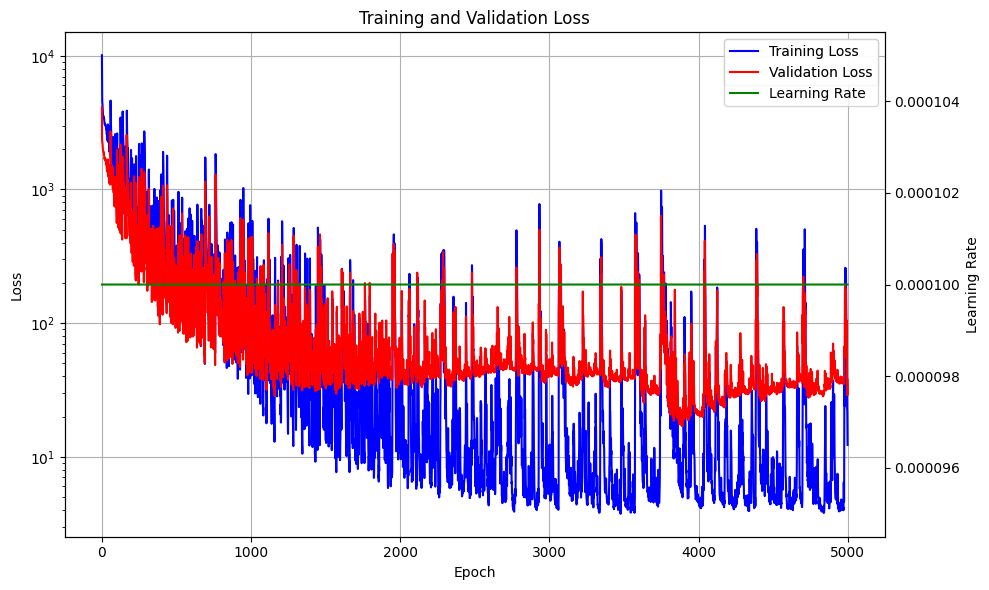

Loss and LR plotted


In [13]:
# Create a figure for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training and validation loss
ax.plot(training_loss, color='blue', label='Training Loss')
ax.plot([val.cpu() for val in avg_val_loss], color='red', label='Validation Loss')
# ax.plot(avg_val_loss, color='red', label='Validation Loss')
# ax.plot(adv_loss, color='orange', label='Adversarial Loss')
ax.grid(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.set_title('Training and Validation Loss')
ax.legend()

# Add a secondary y-axis for learning rate
ax2 = ax.twinx()
ax2.plot(learning_rate, color='green', label='Learning Rate')
# ax2.set_yscale('log')
ax2.set_ylabel('Learning Rate')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig(f'{output_dir}/loss_and_LR.png')

print('Loss and LR plotted')

In [14]:
# Step 1: Collect all latent vectors from real data
all_latents = []
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x,w = batch[0], batch[1]
        embedded = [layer(x[:, i])
                    for i, layer in enumerate(model.embeddings)]
        # (batch_size, n_inputs, model_dim)
        embedded = torch.stack(embedded, dim=1)
        encoded = embedded
        flat = encoded.view(encoded.size(0), -1)
        latents = model.latent_rep(flat)
        all_latents.append(latents.cpu())
all_latents = torch.cat(all_latents, dim=0)  # shape: (N, latent_dim)

# Step 2: Resample from real latent vectors
num_samples = len(dataset_test)
indices = np.random.choice(
    all_latents.shape[0], size=num_samples, replace=True)
z_samples = all_latents[indices].to(device)

# Step 3: Decode
with torch.no_grad():
    dec_input = model.decoder_input(z_samples)
    generated = model.decoder(dec_input)
    generated_data = generated.view(-1, n_objects, 4)

In [15]:
generated_data

tensor([[[ 1.2994e+02, -2.1151e+00,  2.0987e+00,  7.0101e+02],
         [ 5.9220e+01, -1.5040e+00,  2.4241e+00,  2.9411e+02]],

        [[ 1.1745e+02, -1.9543e-01,  6.8672e-01,  1.2308e+02],
         [ 8.5946e+01, -7.6667e-01,  2.0471e+00,  9.8112e+01]],

        [[ 7.6490e+01,  1.1952e+00,  7.1731e-01,  7.9839e+01],
         [ 1.6669e+01,  1.2114e+00,  1.9026e+00,  6.5061e+01]],

        ...,

        [[ 3.9344e+01, -6.7648e-01, -7.7657e-01,  5.5452e+01],
         [ 3.8791e+01, -1.9053e+00,  1.9310e+00,  1.4337e+02]],

        [[ 1.0280e+02, -1.2091e+00,  2.0244e+00,  2.0104e+02],
         [ 2.1143e+01, -1.0138e+00, -4.0290e-01,  3.4763e+01]],

        [[ 4.7944e+01, -8.6176e-01, -4.1515e-01,  7.9372e+01],
         [ 4.0964e+01, -1.7764e+00,  1.8750e+00,  1.2807e+02]]],
       device='cuda:0')

In [16]:
lepton1_data = []
lepton1_gen = []
lepton2_data = []
lepton2_gen = []
mll_data = []
mll_gen = []
for x,_ in tqdm(test_dataloader):
    for leptons in x:
        lepton1_data.append([leptons[0].cpu().numpy()])
        lepton2_data.append([leptons[1].cpu().numpy()])
        mll_data.append(compute_mll(leptons).cpu().numpy())
for leptons in tqdm(generated_data):
    lepton1_gen.append(leptons[0].cpu().numpy())
    lepton2_gen.append(leptons[1].cpu().numpy())
    mll_gen.append(compute_mll(leptons).cpu().numpy())

100%|██████████| 2000/2000 [00:00<00:00, 2752.73it/s]


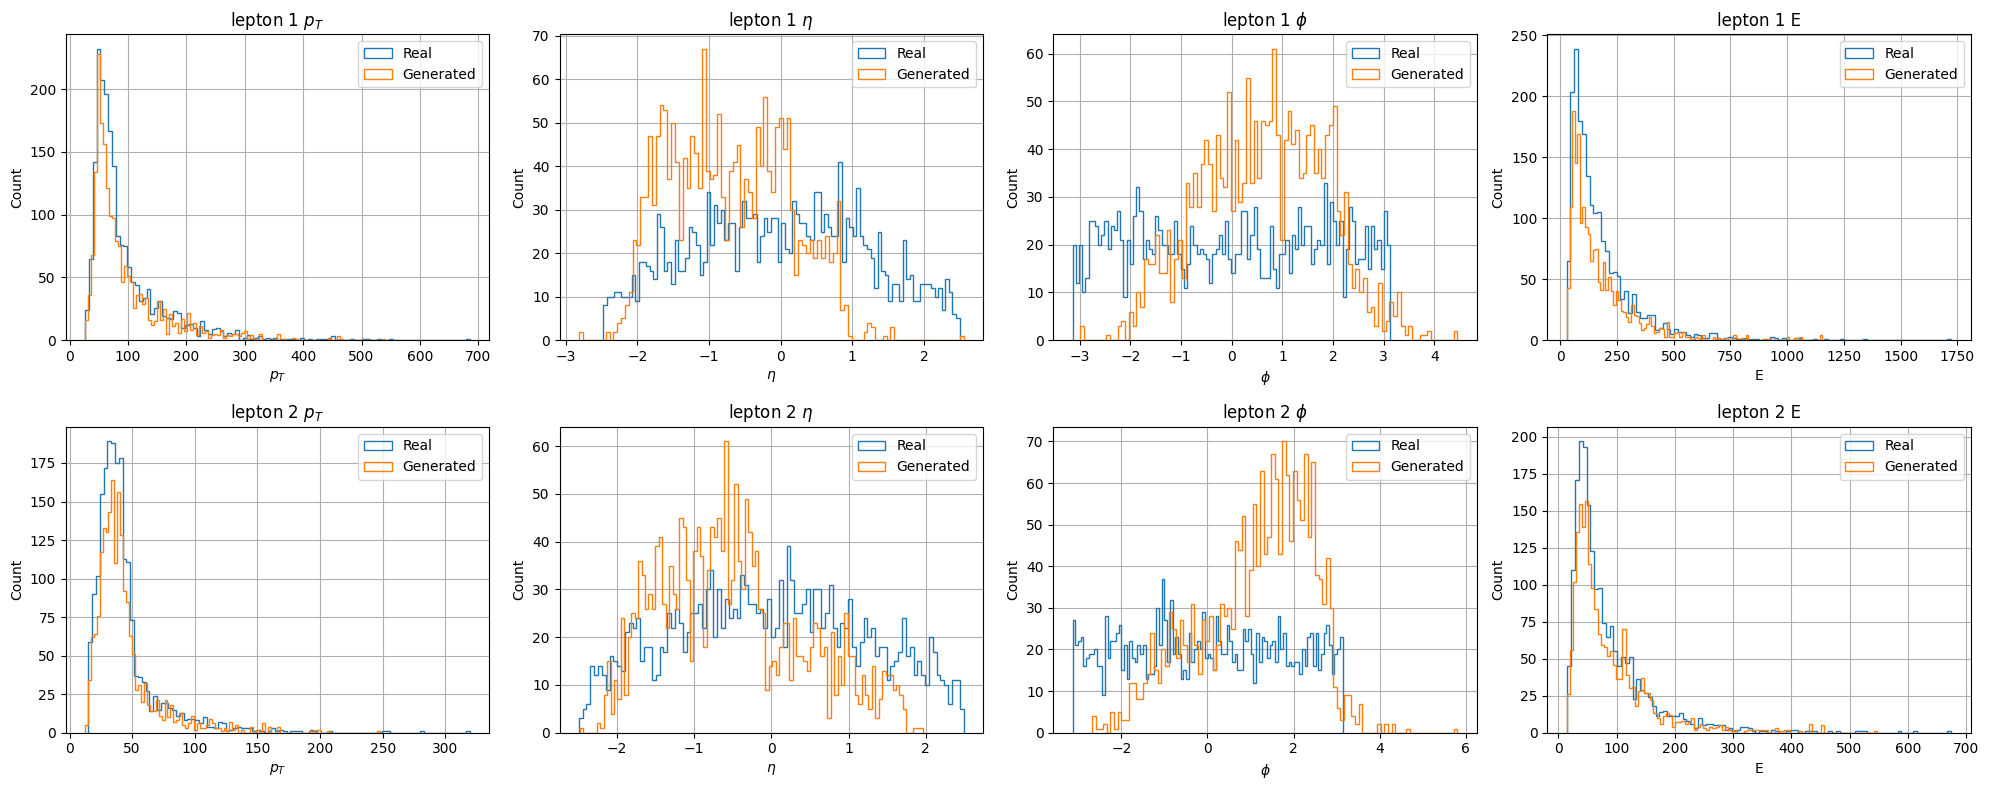

Saved feature comparison plot to outputs/feature_comparison.png


In [17]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# labels = ['$p_T$', '$\eta$', 'E', '$\sin{\phi}$', '$\cos{\phi}$'] # with sin and cos phi
labels = ['$p_T$', r'$\eta$', r'$\phi$', 'E']  # without sin and cos phi
for i in range(4):
    # Plot l1 comparison
    axes[0, i].hist([arr[0][i] for arr in lepton1_data],
                    bins=100, histtype='step', label='Real')
    axes[0, i].hist([arr[i] for arr in lepton1_gen], bins=100,
                    histtype='step', label='Generated')
    axes[0, i].set_xlabel(rf'{labels[i]}')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()
    axes[0, i].set_title(rf'lepton 1 {labels[i]}')
    axes[0, i].grid(True)
    # Plot l2 comparison
    axes[1, i].hist([arr[0][i] for arr in lepton2_data],
                    bins=100, histtype='step', label='Real')
    axes[1, i].hist([arr[i] for arr in lepton2_gen], bins=100,
                    histtype='step', label='Generated')
    axes[1, i].set_xlabel(rf'{labels[i]}')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()
    axes[1, i].set_title(rf'lepton 2 {labels[i]}')
    axes[1, i].grid(True)

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_comparison.png')
plt.show()
plt.close(fig)
print(f'Saved feature comparison plot to {output_dir}/feature_comparison.png')

In [18]:
n_bin_data = int(np.max(mll_data) - np.min(mll_data))
n_bin_gen = int(np.max(mll_gen) - np.min(mll_gen))

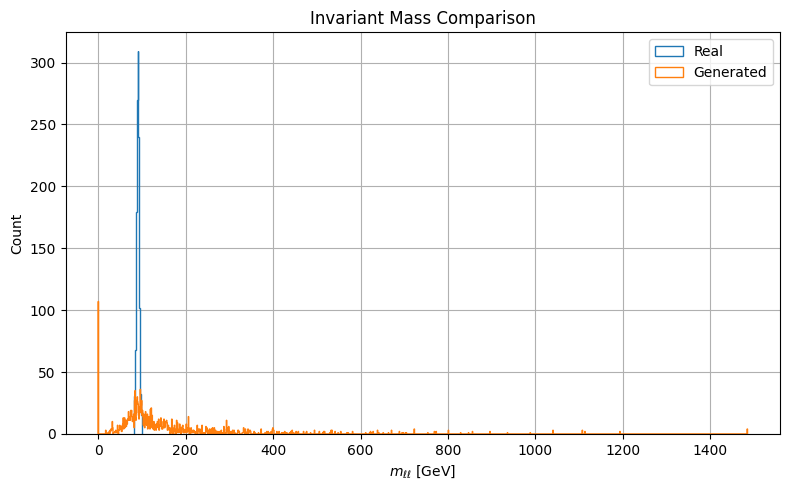

Saved mll comparison plot to outputs/mll_comparison.png


In [19]:
plt.figure(figsize=(8, 5))
plt.hist(mll_data, bins=n_bin_data, histtype='step', label='Real')
plt.hist(mll_gen, bins=n_bin_gen, histtype='step', label='Generated')
plt.xlabel(r'$m_{\ell\ell}$ [GeV]')
# plt.xlim(0, 200)
plt.ylabel('Count')
plt.legend()
plt.title('Invariant Mass Comparison')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/mll_comparison.png')
plt.show()
print(f'Saved mll comparison plot to {output_dir}/mll_comparison.png')

In [20]:
dummy_input = torch.randn(1, n_objects, n_features).to(device)

dynamic_axes = {}
for item in input_features.keys():
    dynamic_axes[item] = {0: 'dynamic_size'}
dynamic_axes['output'] = {0: 'dynamic_size'}

onnx_output = torch.onnx.export(
    model,
    dummy_input,
    f"{output_dir}/model.onnx",
    input_names=list(input_features.keys()),
    output_names=['output'],
    dynamic_axes=dynamic_axes)
print(f"Saved model to {output_dir}/model.onnx")


# simplify the onnx file
os.system(
    f'python -m onnxsim {output_dir}/model.onnx {output_dir}/model_simplified.onnx')

Saved model to outputs/model.onnx
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                    ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                │ 1              │ 0                │
│ Concat             │ 3              │ 2                │
│ Constant           │ 49             │ 40               │
│ Gather             │ 3              │ 3                │
│ Gemm               │ 11             │ 11               │
│ LayerNormalization │ 6              │ 6                │
│ Mod                │ 1              │ 0                ��
│ Relu               │ 8              │ 8                │
│ Reshape            │ 4              │ 2                │
│ Shape              │ 2              │ 1                │
│ Slice              │ 2              │ 0                │
│ Unsqueeze          │ 3              │ 3                │
│ Model Size         │ 2.5MiB    

0